In [1]:
from __future__ import print_function, division

import sys
import platform
import time
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

# this is necessary to use the common functions
# assumes directory structure was maintained
sys.path.insert(0, '../common/')
# from common.torch_utils import train_model,get_device
# from torch_utils import (train_model, 
#                          mnist_dataloader, 
#                          dataset_preview)
from torch_utils import *

# print some versions
print(f'Python Version:      {platform.python_version()}')
print(f'PyTorch Version:     {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')
print(f'CUDA Version:        {torch.version.cuda}')

Python Version:      3.7.8
PyTorch Version:     1.7.1+cu101
Torchvision Version: 0.8.2+cu101
CUDA Version:        10.1


In [2]:
 # use a GPU if there is one available
cuda_availability = torch.cuda.is_available()
if cuda_availability:
    device = torch.device('cuda:{}'.format(torch.cuda.current_device()))
else:
    device = 'cpu'
device_name = torch.cuda.get_device_name()
print('\n***********************************')
print(f'GPU Available:  {cuda_availability}')
print(f'Current Device: {device} ({device_name})')
print('***********************************\n')


***********************************
GPU Available:  True
Current Device: cuda:0 (Tesla T4)
***********************************



In [3]:
# def mnist_dataloader(data_transform, batch_size, 
#                      data_dir='../../data', download=True,
#                      train=True):
#     if not os.path.isdir(data_dir):
#         os.mkdir(data_dir)

#     # get the data
#     dataset = torchvision.datasets.MNIST(root=data_dir, 
#                                         train=train,
#                                         download=download, 
#                                         transform=data_transform)
#     print(f'Data is located in \'{data_dir}\'')

#     # make the dataloader
#     dataloader = torch.utils.data.DataLoader(dataset=dataset, 
#                                              batch_size=batch_size,
#                                              shuffle=True, 
#                                              num_workers=4)
#     return {'dataset':dataset, 'dataloader':dataloader}


# def train_model(device, model, dataloaders, criterion=None, 
#                 optimizer=None, scheduler=None, num_epochs=100, 
#                 checkpoints=10, output_dir='output', 
#                 status=1, train_acc=0, track_steps=False,
#                 seed=414921):
#     ''' Helper function to train PyTorch model based on parameters '''
#     # create the model directory if it doesn't exist
#     if not os.path.isdir(output_dir):
#         os.mkdir(output_dir)

#     # configure the training if it was not specified by user
#     if not criterion:
#         criterion = nn.CrossEntropyLoss()
#     if not optimizer:
#         optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#     if not scheduler:
#         exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

#     # send the model to the device
#     model = model.to(device)
    
#     since = time.time()
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0
#     metrics = []
#     step_metrics = [] # if track_steps=True
#     training_step = 0
#     acc_reached = False
#     for epoch in range(num_epochs):
#         epoch_start_time = time.time()
#         if (epoch) % status == 0 or epoch == num_epochs-1:
#             print()
#             print(f'Epoch {epoch}/{num_epochs - 1}')
#             print('-' * 10)
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()
#             else:
#                 model.eval()
#             epoch_phase_start_time = time.time()
#             running_loss = 0.0
#             running_corrects = 0
#             for inputs, labels in dataloaders[phase]:
#                 step_start_time = time.time()
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)
#                 optimizer.zero_grad()
#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)
#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()
#                         if track_steps:
#                             # store per step metrics (WARNING! lots of data)
#                             step_metrics.append({
#                                 'device': device,
#                                 'epoch': epoch,
#                                 'training_step': training_step,
#                                 'training_step_loss': loss.item(),
#                                 'training_step_time': time.time() - step_start_time
#                             })
#                         training_step += 1
#                 # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)
#             if phase == 'train':
#                 scheduler.step()
#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]
#             epoch_phase_end_time = time.time()
            
#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc.item()
#                 best_model_wts = copy.deepcopy(model.state_dict())
            
#             # check if training accuracy has met target, if so signal exit
#             if (train_acc > 0) and (epoch_acc.item() >= train_acc) and phase == 'train':
#                 acc_reached = True
#                 print()
#                 print(f'Epoch {epoch}/{num_epochs - 1}')
#                 print('-' * 10)
                
#             if (epoch) % status == 0 or epoch == num_epochs-1 or acc_reached:
#                 print(f'{phase} Loss: {round(epoch_loss, 4)} Acc: {round(epoch_acc.item(), 4)}')
#             else:
#                 prog = '-' * int(((epoch) % status))
#                 print('\r{}|{}'.format(prog,epoch),end='')
                
#             # store per epoch metrics
#             metrics.append({
#                             'device': device,
#                             'epoch': epoch,
#                             'training_epoch_loss': loss.item(),
#                             'training_epoch_acc': epoch_acc.item(),
#                             'training_epoch_time': time.time() - epoch_start_time
#                         })

#         ####### save checkpoint after epoch
#         if (epoch > 0 and epoch != num_epochs-1) and \
#             ((epoch+1) % checkpoints == 0 and os.path.isdir(output_dir)):
#             checkpoint=os.path.join(output_dir,
#                                 f'epoch{epoch+1}_checkpoint_model.th')
#             torch.save({
#                 'epoch': epoch + 1,
#                 'state_dict': model.state_dict(),
#                 'best_acc': best_acc,
#             }, checkpoint)
#             # dump the data for later
#             json_file = os.path.join(output_dir,
#                                     f'epoch{epoch+1}_checkpoint_metrics.json')
#             with open(json_file, 'w') as fp:
#                 json.dump(metrics, fp)
#         #######
        
#         # if the target accuracy was reached during this epoch, it is time to exit
#         if acc_reached: 
#             break
    
#     ####### save final checkpoint
#     if os.path.isdir(output_dir):
#         checkpoint= os.path.join(output_dir, 'final_model.th')
#         # save the model
#         torch.save({
#             'state_dict': model.state_dict(),
#             'best_acc': best_acc,
#         }, checkpoint)
#         # dump the data for later
#         metric_path = os.path.join(output_dir,'final_metrics.json')
#         with open(metric_path, 'w') as fp:
#             json.dump(metrics, fp)
#     #######
    
#     time_elapsed = time.time() - since
#     print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
#     print(f'Best val Acc: {round(best_acc, 4)}')
#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     # set up return structures
#     metrics_df = pd.DataFrame(data=metrics)
#     step_metrics_df = pd.DataFrame(data=step_metrics) if step_metrics else None
        
#     return model, metrics_df, step_metrics_df


#     def get_device(verbose=False):
#         # use a GPU if there is one available
#         cuda_availability = torch.cuda.is_available()
#         if cuda_availability:
#             device = torch.device('cuda:{}'.format(torch.cuda.current_device()))
#         else:
#             device = 'cpu'
#         device_name = torch.cuda.get_device_name()
#         print('\n***********************************')
#         print(f'GPU Available:  {cuda_availability}')
#         print(f'Current Device: {device} ({device_name})')
#         print('***********************************\n')

Data will be located in '../../data'
Dataset sizes: {'train': 60000, 'val': 9900, 'pred': 100}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


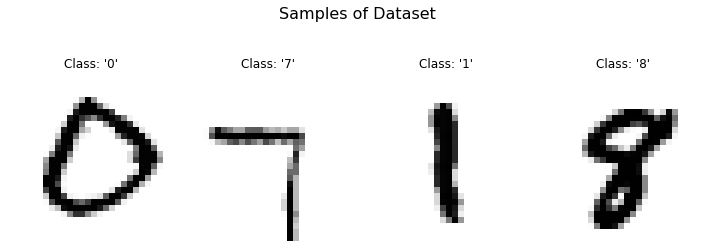

In [4]:
BATCH_SIZE = 32

data_transforms = {
    'train': transforms.Compose([
#         transform.Resize(224,224), # MNIST are 28x28, ResNet used 224x224
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        #         transform.Resize(224,224), # MNIST are 28x28, ResNet used 224x224
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}
# datasets = {}
# dataloaders = {}
# dataset_sizes = {}
# for phase in data_transforms:
#     if phase == 'val':
#         tmp = mnist_dataloader(data_transforms[phase],batch_size=BATCH_SIZE)
#     elif phase == 'predict':
#         tmp = mnist_dataloader(data_transforms[phase],batch_size=4)
#     else:         
#         tmp = mnist_dataloader(data_transforms[phase],batch_size=BATCH_SIZE,train=False)
#     datasets[phase] = tmp['dataset']
#     dataloaders[phase] = tmp['dataloader']
#     dataset_sizes[phase] = tmp['dataset_size']
    
tmp = mnist_dataloader(data_transforms,batch_size=BATCH_SIZE,pred_size=0.01)
dataloaders, dataset_sizes, class_names = tmp 
print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders['val'])


# train_set = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True,
#                                         download=False, transform=data_transforms['train'])
# val_set = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False,
#                                        download=False, transform=data_transforms['val'])
# image_datasets = {'train': train_set, 'val': val_set}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCHSIZE,
#                                               shuffle=True, num_workers=4)
#                for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dataset sizes: {dataset_sizes}")
# print(f"Class names: {class_names}")

In [ ]:
# Fetch PyTorch model for reset50
# Use Resnet18, as our dataset is small and only has two classes
# model = models.resnet18(pretrained=True)
model = models.resnet50(pretrained=True)
# Note the considerations we must make:
#   -> MNIST data are 1-channel (grascale) of size and has 10 output classes
#   -> ResNet model expects 3-channel (RGB) images of size 224x224 as input and has 1000 output classes
#   == We must changet the last fully connected layer to match 10 classes, and transform the input to be 224
num_classes = 10
# prepare the pre-trained model
num_features = model.fc.in_features
# change the output layer to match number of new classes
model.fc = nn.Linear(num_features, num_classes)
# change the first conv layer for single channel images
model.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
# ref: https://discuss.pytorch.org/t/altering-resnet18-for-single-channel-images/29198/10

# move model to the GPU
cudnn.benchmark = True

model, results_df,_ = train_model(device, model, dataloaders, dataset_sizes, num_epochs=3)

# save the data for others to use
# results_file = 'resnet18_{}.csv'.format(hardware)
# df_path = os.path.join(save_dir,results_file)
# results_df.to_csv(df_path,columns=results_df.columns)

tensor([6, 5, 6, 4, 9, 1, 2, 4, 4, 2, 9, 8, 1, 3, 9, 4, 3, 8, 8, 4, 4, 0, 5, 7,
        5, 1, 4, 6, 1, 1, 9, 6])


[]

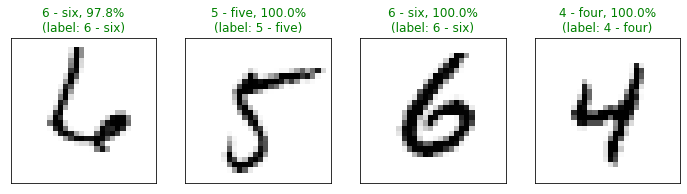

In [26]:
# Evaluate the model
model.eval()
inputs, labels = next(iter(dataloaders['pred']))
inputs = inputs.cuda()
# make predictions an plot the results
plot_classes_preds(model,inputs,labels,class_names) 
plt.plot()